In [80]:
import numpy as np # linear algebra
import random
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import cv2
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.applications import vgg16
from tensorflow.keras.models import Model,load_model
import keras
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose,AveragePooling2D, MaxPooling2D,UpSampling2D,LeakyReLU, concatenate, Dropout,BatchNormalization,Activation
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint
import pandas as pd
from tensorflow.keras.optimizers import Adam
#import tensorflow.keras import optimizers
from sklearn.model_selection import train_test_split
from numpy.random import seed
seed(123)
import tensorflow as tf
# import tensorflow.compat.v1 as tf
# tf.disable_v2_behavior()
#from tensorflow.python.keras.optimizers import Adam
tf.random.set_seed(123)
from tensorflow.python.keras import backend as K
# from keras import backend as K
from tensorflow.keras.models import Sequential
session_conf =  tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
#session_conf =  tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
#sess = tf.Session(graph=tf.default_graph(), config=session_conf)
K.set_session(sess)
from skimage.transform import resize
from sklearn.metrics import jaccard_score
from keras import metrics
import csv

In [81]:
#print(os.listdir())

In [82]:
# print(os.getcwd())
# os.chdir(r'data/train/train_mask')
# print(os.getcwd())

In [83]:
#pic = cv2.imread('cod_100.png')

In [84]:
#plt.imshow(pic)

In [85]:
#print(os.getcwd())


In [86]:
path= (r'C:/Users/k v/Documents/REU/ShorelineDetection/data/')
model_path = (r'C:/Users/k v/Documents/REU/ShorelineDetection/model/')
result_path = (r'C:/Users/k v/Documents/REU/ShorelineDetection/results/')

In [87]:
#print(os.listdir(path+'train/train_img'))

In [88]:
#print(os.listdir(path+'train/train_mask'))

In [89]:
# plt.figure(figsize=(30,30))
# plt.subplot(5,5,1)
# img = cv2.imread(path+"train/train_img/cod_100.jpg")  
# img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# img1 = cv2.resize(img, (500, 500))
# img2 = np.array(img1)
# plt.imshow(img1, cmap='BrBG')
# plt.subplot(5,5,1+1)
# img = cv2.imread(path+"train/train_mask/cod_100.png")  
# img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# plt.imshow(img)
# # plt.subplot(5,5,1+2)
# # img = cv.imread(InputPath+"clean/clean0001.png")  
# # img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
# # plt.imshow(img)


In [90]:
# c = sorted(os.listdir(path+'train/train_img'))
# d = sorted(os.listdir(path+'train/train_mask'))
# print(len(d))
# print(len(c))

In [91]:
def get_label_info(csv_path):
    filename, file_extension = os.path.splitext(csv_path)
    if not file_extension == ".csv":
        return ValueError("File is not a CSV!")

    class_names = []
    label_values = []
    with open(csv_path, 'r') as csvfile:
        file_reader = csv.reader(csvfile, delimiter=',')
        header = next(file_reader)
        for row in file_reader:
            class_names.append(row[0])
            label_values.append([int(row[1]), int(row[2]), int(row[3])])
        # print(class_dict)
    return class_names, label_values

In [92]:
class_name_lists, label_values = get_label_info('C:/Users/k v/Documents/REU/ShorelineDetection/data/class_dict.csv')

In [93]:
num_classes = len(label_values)
num_classes

2

In [94]:
def one_hot_it(label, label_values):
    semantic_map = []
    for colour in label_values:
        # colour_map = np.full((label.shape[0], label.shape[1], label.shape[2]), colour, dtype=int)
        equality = np.equal(label, colour)
        class_map = np.all(equality, axis = -1)
        semantic_map.append(class_map)
    semantic_map = np.stack(semantic_map, axis=-1)
    # print("Time 2 = ", time.time() - st)

    return semantic_map

In [99]:
def ExtractData(path):
    SourceImg = sorted(os.listdir(path+'train_img'))
    TargetImg = sorted(os.listdir(path+'train_mask'))
   
    X_=[]
    y_=[]
    count=0
    for i in range(len(SourceImg)):
        if count<2165:
            count=count+1
            img_1 = cv2.imread(path+'train_img/'+SourceImg[i])
            img_1 = cv2.cvtColor(img_1, cv2.COLOR_BGR2RGB)
            img_1 = cv2.resize(img_1,(500,500))
            img_1 = img_1/255.0
            X_.append(img_1)
            img_2 = cv2.imread(path+'train_mask/'+TargetImg[i])
            img_2 = cv2.cvtColor(img_2, cv2.COLOR_BGR2RGB)
            img_2 = cv2.resize(img_2,(500,500))
            img_2 = img_2/255.0
            y_.append(img_2)
    X_ = np.array(X_)
    y_ = np.array(y_)
    
    return X_,y_

In [100]:
X_,y_ = ExtractData(path)

In [101]:
#y_.shape


In [102]:
#X_.shape

In [103]:
def AugmentData(X_, y_):
    X_2=[]
    y_2=[]
    count=0
    for i in range(len(X_)):
        if count<2165:
            count=count+1

            # Augment training images
            #img_x_1 = tf.placeholder(dtype = tf.float32, shape = X_[i])
            temp_x = []
            temp_x_1 = X_[i]
            temp_x_2 = tf.image.flip_up_down(temp_x_1)
            temp_x_3 = tf.image.flip_left_right(temp_x_1)
            temp_x_4 = tf.image.flip_up_down(temp_x_3)
            temp_x_5 = tf.image.rot90(temp_x_1)
            temp_x_6 = tf.image.rot90(temp_x_2)
            temp_x_7 = tf.image.rot90(temp_x_3)
            temp_x_8 = tf.image.rot90(temp_x_4)
            X_2.append(np.array(temp_x_1))
            X_2.append(np.array(temp_x_2))
            X_2.append(np.array(temp_x_3))
            X_2.append(np.array(temp_x_4))
            X_2.append(np.array(temp_x_5))
            X_2.append(np.array(temp_x_6))
            X_2.append(np.array(temp_x_7))
            X_2.append(np.array(temp_x_8))

            # Augment training masks
            # The augmentations here are identicial to their corresponding image counterparts.
            #img_y_1 = tf.placeholder(dtype = tf.float32, shape = y_[i])
            temp_y = []
            temp_y_1 = y_[i]
            temp_y_2 = tf.image.flip_up_down(temp_y_1)
            temp_y_3 = tf.image.flip_left_right(temp_y_1)
            temp_y_4 = tf.image.flip_up_down(temp_y_3)
            temp_y_5 = tf.image.rot90(temp_y_1)
            temp_y_6 = tf.image.rot90(temp_y_2)
            temp_y_7 = tf.image.rot90(temp_y_3)
            temp_y_8 = tf.image.rot90(temp_y_4)
            y_2.append(np.array(temp_y_1))
            y_2.append(np.array(temp_y_2))
            y_2.append(np.array(temp_y_3))
            y_2.append(np.array(temp_y_4))
            y_2.append(np.array(temp_y_5))
            y_2.append(np.array(temp_y_6))
            y_2.append(np.array(temp_y_7))
            y_2.append(np.array(temp_y_8))
    X_2 = np.array(X_2)
    y_2 = np.array(y_2)
    
    return X_2,y_2

In [104]:
X_,y_ = AugmentData(X_, y_)

In [105]:
len(X_)

1224

In [106]:
len(y_)

1224

In [107]:
# Split train and valid
X_train, X_test, y_train, y_test = train_test_split(X_, y_, test_size=0.1, random_state=42)

In [108]:
#len(X_train)

In [109]:
#len(y_train)

In [110]:
#len(X_test)

In [111]:
#len(y_test)

In [112]:
input_shape = (500, 500, 3)
VGG16_weight = "../vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5"
VGG16_MODEL=tf.keras.applications.VGG16(input_shape=input_shape,
                                               include_top=False,
                                               weights='imagenet')
VGG16 = vgg16.VGG16(include_top=False, weights='imagenet', input_shape=input_shape)

print('Model loaded.')

Model loaded.


In [113]:
output_ = VGG16.output
output_

<tf.Tensor 'block5_pool_3/Identity:0' shape=(None, 15, 15, 512) dtype=float32>

In [114]:
set_trainable = False
for layer in VGG16.layers:
    if layer.name in ['block1_conv1']:
        set_trainable = True
    if layer.name in ['block1_pool','block2_pool','block3_pool','block4_pool','block5_pool']:
        layer.trainable = False

In [115]:
vgg_model = Model(VGG16.input, output_)
layers = [(layer, layer.name, layer.trainable) for layer in vgg_model.layers]
pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable'])

,Layer Type,Layer Name,Layer Trainable
0,<tensorflow.python.keras.engine.input_layer.In...,input_3,True
1,<tensorflow.python.keras.layers.convolutional....,block1_conv1,True
2,<tensorflow.python.keras.layers.convolutional....,block1_conv2,True
3,<tensorflow.python.keras.layers.pooling.MaxPoo...,block1_pool,False
4,<tensorflow.python.keras.layers.convolutional....,block2_conv1,True
5,<tensorflow.python.keras.layers.convolutional....,block2_conv2,True
6,<tensorflow.python.keras.layers.pooling.MaxPoo...,block2_pool,False
7,<tensorflow.python.keras.layers.convolutional....,block3_conv1,True
8,<tensorflow.python.keras.layers.convolutional....,block3_conv2,True
9,<tensorflow.python.keras.layers.convolutional....,block3_conv3,True


In [116]:
vgg_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 500, 500, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 500, 500, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 500, 500, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 250, 250, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 250, 250, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 250, 250, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 125, 125, 128)     0   

In [117]:
K.clear_session()
def ModelEnhancer():
    input_shape = (500, 500, 3)
#     VGG16_weight = "../input/keras-pretrained-models/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5"
#     VGG16 = vgg16.VGG16(include_top=False, weights=VGG16_weight, input_shape=input_shape)
    VGG16=tf.keras.applications.VGG16( input_shape=input_shape,
                                               include_top=False,
                                               weights='imagenet')
    last_layer = VGG16.output
    
    set_trainable = False
    for layer in VGG16.layers:
        if layer.name in ['block1_conv1']:
            set_trainable = True
        if layer.name in ['block1_pool','block2_pool','block3_pool','block4_pool','block5_pool']:
            layer.trainable = False
   
    model_ = Conv2DTranspose(256,(3,3),strides=(2, 2))(last_layer)
    model_ = LeakyReLU(0.1)(model_)
    model_ = BatchNormalization()(model_)    
    
    concat_1 = concatenate([model_,VGG16.get_layer("block5_conv3").output])
    
    model_ = Conv2D(512,(3,3),strides=(1, 1),padding='same')(concat_1)
    model_ = LeakyReLU(0.1)(model_)
    model_ = BatchNormalization()(model_)
    
    model_ = Conv2DTranspose(512,(3,3),strides=(2, 2),padding='same')(model_)
    model_ = LeakyReLU(0.1)(model_)
    model_ = BatchNormalization()(model_) 
    
    concat_2 = concatenate([model_,VGG16.get_layer("block4_conv3").output])
    
    model_ = Conv2D(512,(3,3),strides=(1, 1),padding='same')(concat_2)
    model_ = LeakyReLU(0.1)(model_)
    model_ = BatchNormalization()(model_)
    
    model_ = Conv2DTranspose(512,(3,3),strides=(2, 2))(model_)
    model_ = LeakyReLU(0.1)(model_)
    model_ = BatchNormalization()(model_) 
    
    concat_3 = concatenate([model_,VGG16.get_layer("block3_conv3").output])
    
    model_ = Conv2D(256,(3,3),strides=(1, 1),padding='same')(concat_3)
    model_ = LeakyReLU(0.1)(model_)
    model_ = BatchNormalization()(model_)
    
    model_ = Conv2DTranspose(256,(3,3),strides=(2, 2),padding='same')(model_)
    model_ = LeakyReLU(0.1)(model_)
    model_ = BatchNormalization()(model_) 
    
    concat_4 = concatenate([model_,VGG16.get_layer("block2_conv2").output])
    
    model_ = Conv2D(128,(3,3),strides=(1, 1),padding='same')(concat_4)
    model_ = LeakyReLU(0.1)(model_)
    model_ = BatchNormalization()(model_)
    
    model_ = Conv2DTranspose(128,(3,3),strides=(2, 2),padding='same')(model_)
    model_ = LeakyReLU(0.1)(model_)
    model_ = BatchNormalization()(model_) 
    
    concat_5 = concatenate([model_,VGG16.get_layer("block1_conv2").output])
    
    model_ = Conv2D(64,(3,3),strides=(1, 1),padding='same')(concat_5)
    model_ = LeakyReLU(0.1)(model_)
    model_ = BatchNormalization()(model_)
    
    model_ = Conv2D(32,(3,3),strides=(1, 1),padding='same')(model_)
    model_ = LeakyReLU(0.1)(model_)
    model_ = BatchNormalization()(model_)
    
    model_ = Conv2D(3,(3,3),strides=(1, 1),padding='same')(model_)
    model_ = LeakyReLU(0.1)(model_)
    model_ = BatchNormalization()(model_)
    
    model_ = Model(VGG16.input,model_)
    
    return model_

In [118]:
Model_ = ModelEnhancer()
Model_.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 500, 500, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 500, 500, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 500, 500, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 250, 250, 64) 0           block1_conv2[0][0]               
______________________________________________________________________________________________

In [119]:
# from keras.utils.vis_utils import plot_model
# plot_model(Model_,to_file=path+"model_.png",show_shapes=True, show_layer_names=True)
# from IPython.display import Image
# Image(retina=True, filename='model_.png')


In [120]:
Model_.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])
#Adam(lr = 1e-4)

In [121]:
checkpointer = ModelCheckpoint(model_path+'model_TL_UNET.h5', verbose=1, mode='auto', monitor='loss',save_best_only=True)

In [122]:
def GenerateInputs(X,y):
    for i in range(len(X)):
        X_input = X[i].reshape(1,500,500,3)
        y_input = y[i].reshape(1,500,500,3)
        yield (X_input,y_input)
Model_.fit(GenerateInputs(X_train,y_train), epochs=5, validation_data=(X_test,y_test), verbose=1, callbacks=[checkpointer], steps_per_epoch=2,
                     shuffle=True)

  ...
    to  
  ['...']
Train for 2 steps, validate on 123 samples
Epoch 1/5
1/2 [==============>...............] - ETA: 4s - loss: 2.9814 - accuracy: 0.5630
Epoch 00001: loss improved from inf to 3.09869, saving model to C:/Users/k v/Documents/REU/ShorelineDetection/model/model_TL_UNET.h5
2/2 [==============================] - 14s 7s/step - loss: 3.0987 - accuracy: 0.5516 - val_loss: 9.5868 - val_accuracy: 0.1731
Epoch 2/5
1/2 [==============>...............] - ETA: 0s - loss: 2.9571 - accuracy: 0.5546
Epoch 00002: loss improved from 3.09869 to 2.88775, saving model to C:/Users/k v/Documents/REU/ShorelineDetection/model/model_TL_UNET.h5
2/2 [==============================] - 10s 5s/step - loss: 2.8877 - accuracy: 0.5620 - val_loss: 9.5729 - val_accuracy: 0.1750
Epoch 3/5
1/2 [==============>...............] - ETA: 0s - loss: 3.0308 - accuracy: 0.5579
Epoch 00003: loss did not improve from 2.88775
2/2 [==============================] - 9s 5s/step - loss: 3.0108 - accuracy: 0.5571 - va

In [123]:
TransferLearningModel = load_model(model_path+'model_TL_UNET.h5')

In [124]:
TransferLearningModel.metrics_names

['loss', 'accuracy']

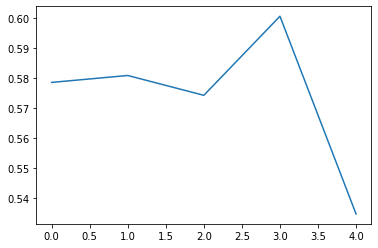

In [125]:
results.history['accuracy']
plt.plot(results.history['accuracy'])

In [ ]:
#TransferLearningModel.evaluate(X_test, y_test)

In [ ]:
X_test= []
for i in X_test:
    img_x = cv2.cvtColor(i, cv2.COLOR_BGR2RGB)
    img_x = cv2.resize(i,(500,500), 1)
    img_x = img_x.reshape(1,500,500,3)
    X_test.append(img_x)

In [52]:
from sklearn.metrics import classification_report

In [58]:
#prediction = TransferLearningModel.evaluate(X_test)

In [127]:
img_x = cv2.imread(path + "valid_img/bob_0.jpg")
img_x = cv2.cvtColor(img_x, cv2.COLOR_BGR2RGB)
img_x = cv2.resize(img_x,(500,500), 1)
img_x = img_x.reshape(1,500,500,3)

In [128]:
prediction = TransferLearningModel.predict(img_x)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


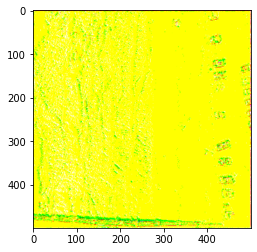

In [134]:
pred = prediction.reshape(500,500, 3)
pred = cv2.cvtColor(pred, cv2.COLOR_BGR2RGB)
pred_ = cv2.resize(pred, (500,500), 1)
plt.imshow(pred_, cmap='seismic', interpolation='bilinear')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


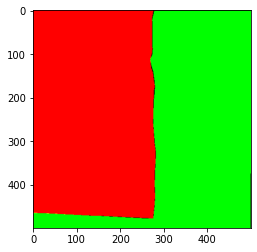

In [133]:
img = cv2.imread(path+"valid_mask/bob_0.png")  
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = img*255.0
img = cv2.resize(img,(500,500), 1)
plt.imshow(img, cmap='gray', vmin=0, vmax=255)

In [72]:
img_x.shape


(1, 500, 500, 3)

In [75]:
img.shape

(500, 500, 3)

In [76]:
def compute_mean_iou(pred, label):

    unique_labels = np.unique(label)
    num_unique_labels = len(unique_labels);

    I = np.zeros(num_unique_labels)
    U = np.zeros(num_unique_labels)

    for index, val in enumerate(unique_labels):
        pred_i = pred == val
        label_i = label == val

        I[index] = float(np.sum(np.logical_and(label_i, pred_i)))
        U[index] = float(np.sum(np.logical_or(label_i, pred_i)))


    mean_iou = np.mean(I / U)
    return mean_iou

In [79]:
compute_mean_iou(img_x, img)

7.911548889525013e-05

In [ ]:
plt.figure(figsize=(30,30))
plt.subplot(5,5,1)
image_0 = cv2.imread(path+"valid/valid_img/bob_0.jpg")  
image_0 = cv2.cvtColor(image_0, cv2.COLOR_BGR2RGB)
image_0 = cv2.resize(image_0, (710,470))
plt.title("Actual Image",fontsize=20)
plt.imshow(image_0)
image_0 = cv2.resize(image_0,(500,500))
image_0 = image_0.reshape(1,500,500,3)
prediction_0 = TransferLearningModel.predict(image_0)
pred_0 = prediction_0.reshape(500,500,3)
pred_0 = cv2.resize(pred_0,(710,470))
plt.subplot(5,5,1+1)
plt.title("Segmented Image (prediction)",fontsize=20)
plt.imshow(pred_0, cmap='seismic')
plt.subplot(5,5,1+2)
img_g0 = cv2.imread(path+"valid/valid_mask/bob_0.png")  
img_g0 = cv2.cvtColor(img_g0, cv2.COLOR_BGR2GRAY)
img2 = cv2.resize(img_g0,(710,470), 3)
plt.title("Mask",fontsize=20)
plt.imshow(img2, cmap='gray')

In [ ]:
#print(os.getcwd())

In [ ]:
cv2.imwrite(result_path+'pred_6.jpg', pred_0)

In [ ]:
res = TransferLearningModel.evaluate(X_test, y_test)

In [ ]:
#img2

In [ ]:
# img = cv2.imread(path+'test/test_img/cod_1000.jpg')
# img = cv2.resize(img,(500,500), 1)
# img = img.reshape(1,500,500,3)
# prediction2 = TransferLearningModel.predict(img)

In [ ]:
# pred2 = prediction2.reshape(500,500, 3)
# plt.imshow(pred2)


In [ ]:
# mask = cv2.imread(path+'test/test_mask/cod_1000.png')
# mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
# mask = cv2.resize(mask,(500,500), 1)
# plt.imshow(mask, cmap='gray', vmin=0, vmax=255)

In [ ]:
# prediction2= prediction2.reshape
# prediction2 = img_to_array((prediction2), dtype=np.uint8)

# ix = load_img(prediction2, color_mode = 'grayscale')
# has_mask = y_[ix].max() > 0 
# fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 15))
# ax1.imshow(X_[ix, ..., 0], cmap = 'seismic',interpolation = 'bilinear')
# if has_mask: # if water
#     # draw a boundary(contour) in the original image separating water and not-water areas
#         ax1.contour(y_[ix].squeeze(), colors = 'k', linewidths = 5, levels = [0.5])
# ax1.set_title('Seismic')
        
# ax2.imshow(y_[ix].squeeze(), cmap = 'gray', interpolation = 'bilinear')
# ax2.set_title('Salt')

In [ ]:
# prediction2.shape


In [ ]:
# TransferLearningModel.evaluate('images/test/test_img', 'images/test/test_mask')